In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 1. Загружаем изображение (это должен быть кадр из видео)

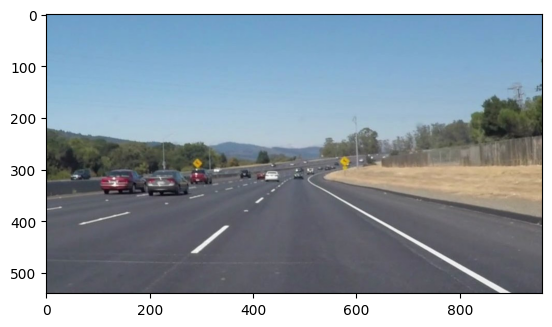

In [2]:
inputimage = cv2.imread("./images/01. solidWhiteCurve.jpg")

# plt.imshow(inputimage); # Внимание! В OpenCV формат изображений BGR а не RGB
inputimage = cv2.cvtColor(inputimage, cv2.COLOR_BGR2RGB)
plt.imshow(inputimage);

### 2. Применяем детектор краев Canny

Преобразуем исходное изображение в оттенки серого

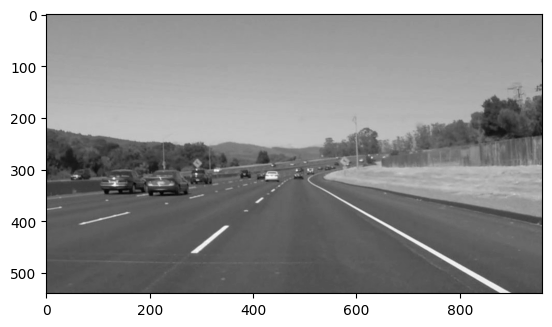

In [3]:
gray = cv2.cvtColor(inputimage, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray');

Для уменьшения шума применяем размытие по Гаусу 5x5

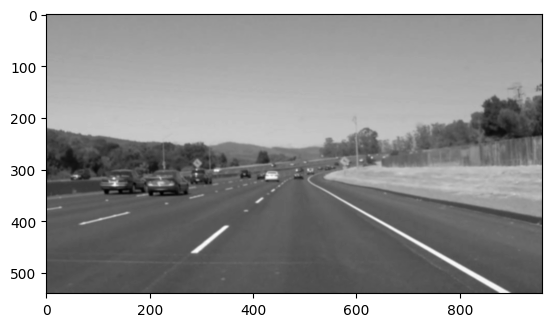

In [4]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blur, cmap='gray');

Применяем детектор краев Canny с параметрами minVal=50 и maxVal=150

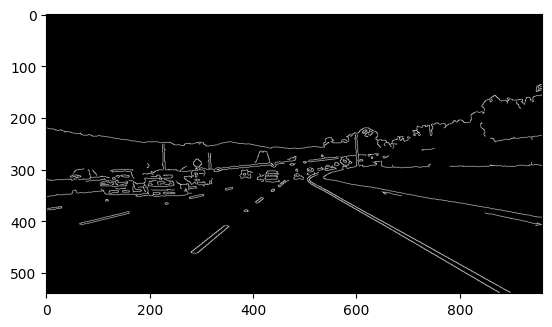

In [5]:
canny = cv2.Canny(blur, 50, 150)
plt.imshow(canny, cmap='gray');

Создадим функция для использования кода в скрипте

In [6]:
# Возвращает края, найденые на изображении
def canny_edge_detector(frame):
    
    # Преобразуем исходное изображение в оттенки серого
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Для уменьшения шума применяем размытие по Гаусу 5x5
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Применяем детектор краев Canny с параметрами minVal=50 и maxVal=150
    canny = cv2.Canny(blur, 50, 150)
    
    return canny

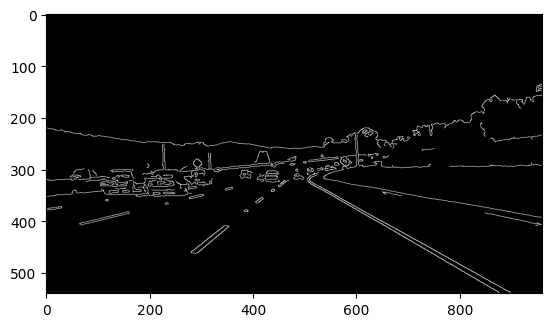

In [7]:
# Применяем детектор краев Canny
canny_edges = canny_edge_detector(inputimage)
plt.imshow(cv2.cvtColor(canny_edges, cv2.COLOR_BGR2RGB));

### 3. Удаляем ненужные сегменты изображения и сохраняем только полосу движения.

In [8]:
# Берем ширину и высоту изображения
width = canny.shape[1]
height = canny.shape[0]

print(width)
print(height)

960
540


Определяем координаты треугольника для выделения области полосы движения и удаления других ненужных частей изображения.

- Определяется тремя координатами (x, y)

- Необходимо подстраивать для другого ракурса

In [9]:
# Определяем координаты треугольника для выделения области полосы движения и удаления других ненужных частей изображения.
# Определяется тремя координатами (x, y)

polygons = np.array([ 
        [(100, height), (round(width/2), round(height/2)), (920, height)] 
        ])

polygons

array([[[100, 540],
        [480, 270],
        [920, 540]]])

Создаем маску

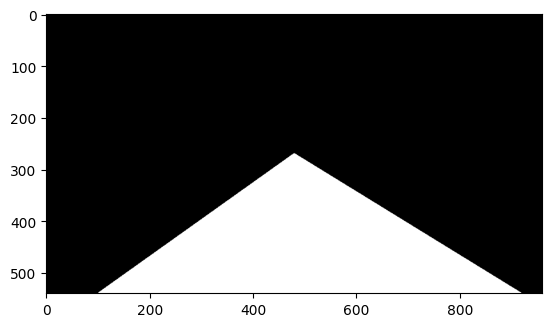

In [10]:
mask = np.zeros_like(canny) 
cv2.fillPoly(mask, polygons, 255)  # 255 это цвет маски

plt.imshow(mask, cmap='gray');

Применяем побитовое логическое AND между изображением с краями (canny) и изображением маски

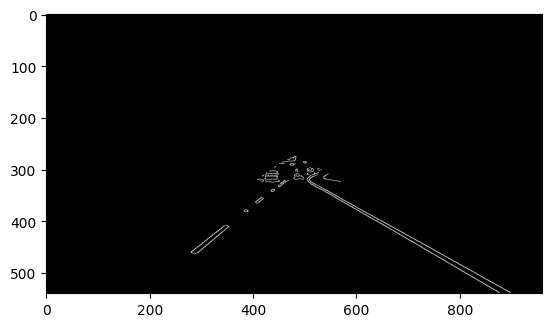

In [11]:
masked_image = cv2.bitwise_and(canny, mask)

plt.imshow(masked_image, cmap='gray');

Создадим функция для использования кода в скрипте

In [22]:
# Накладывает маску на изображение, оставляя только полосу дороги
def ROI_mask(image):
    
    # Берем высоту и ширину изображения
    height = image.shape[0]
    width = image.shape[1]

    
    # Определяем координаты треугольника для выделения области полосы движения и удаления других ненужных частей изображения.
    polygons = np.array([ 
        [(100, height), (round(width/2), round(height/2)), (920, height)] 
        ]) 
    
    # Создаем маску
    mask = np.zeros_like(image) 
    cv2.fillPoly(mask, polygons, 255)  ## 255 это цвет маски
    
    # Применяем побитовое логическое AND между изображением с краями (canny) и изображением маски
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

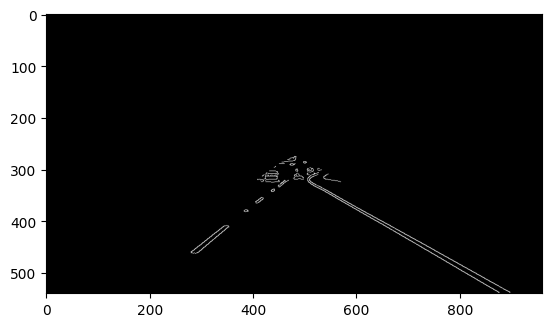

In [23]:
# Remove irrelevant segments of the image and retain only the lane portion
cropped_image = ROI_mask(canny_edges)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB));

### 4. Применяем Преобразование Хафа для обнаружения полос движения по обнаруженным краям

Преобразование Хафа — это алгоритм, используемый для поиска геометрических фигур на изображении.

https://habr.com/ru/companies/otus/articles/745946/

In [33]:
lines = cv2.HoughLinesP(
    cropped_image,
    rho=2,              # Distance resolution in pixels
    theta=np.pi / 180,  # Angle resolution in radians
    threshold=100,      # Min. number of intersecting points to detect a line  
    lines=np.array([]), # Vector to return start and end points of the lines indicated by [x1, y1, x2, y2] 
    minLineLength=40,   # Line segments shorter than this are rejected
    maxLineGap=25       # Max gap allowed between points on the same line
)

Функция преобразования Хафа возвращает массив обнаруженных линий. Теперь мы нарисуем эти обнаруженные линии на оригинальном изображении.

In [34]:
lines

array([[[483, 311, 877, 538]],

       [[484, 309, 897, 538]],

       [[389, 382, 503, 287]],

       [[389, 380, 487, 309]],

       [[293, 462, 353, 412]],

       [[280, 460, 346, 410]]], dtype=int32)

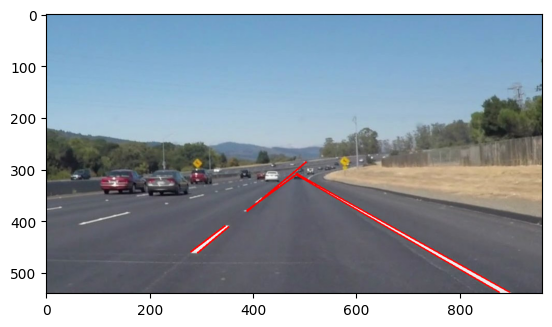

In [35]:
image_lines = np.copy(inputimage)
color=[255, 0, 0]
thickness = 2

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image_lines, (x1, y1), (x2, y2), color, thickness)

# plt.figure(figsize=(12, 8))   
plt.imshow(image_lines);

У нас обнаружено несколько линий для каждой линии полосы движения. Нам нужно усреднить все эти линии и нарисовать одну линию для каждой линии полосы движения. Нам также необходимо экстраполировать линии полосы движения, чтобы охватить всю длину линии полосы движения.

### 5. Усреднение и экстраполяция линий полосы движения

In [38]:
def get_coordinates (image, params):
    slope, intercept = params 
    y1 = image.shape[0]     
    y2 = int(y1 * (3/5)) # Setting y2 at 3/5th from y1
    x1 = int((y1 - intercept) / slope) # Deriving from y = mx + c
    x2 = int((y2 - intercept) / slope) 
    
    return np.array([x1, y1, x2, y2])

# Returns averaged lines on left and right sides of the image
def avg_lines(image, lines): 
    
    left = [] 
    right = [] 
    
    for line in lines: 
        x1, y1, x2, y2 = line.reshape(4)
        # print(x1, y1, x2, y2)
          
        # Fit polynomial, find intercept and slope 
        params = np.polyfit((x1, x2), (y1, y2), 1)  
        slope = params[0] 
        y_intercept = params[1] 
        
        # print(slope)
        if slope < 0: 
            left.append((slope, y_intercept)) #Negative slope = left lane
        else: 
            right.append((slope, y_intercept)) #Positive slope = right lane
    
    # Avg over all values for a single slope and y-intercept value for each line
    if left != []:
        left_avg = np.average(left, axis = 0) 
        left_line = get_coordinates(image, left_avg) 
    else:
        left_line = [0, 0, 0, 0]
    
    if right != []:
        right_avg = np.average(right, axis = 0) 
        right_line = get_coordinates(image, right_avg) 
    else:
        right_line = [0, 0, 0, 0]
  
    return np.array([left_line, right_line])


# Draws lines of given thickness over an image
def draw_lines(image, lines, thickness): 
    line_image = np.zeros_like(image)
    color=[255, 0, 0]
    
    if lines is not None: 
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)

            
    # Merge the image with drawn lines onto the original.
    combined_image = cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)
    
    return combined_image

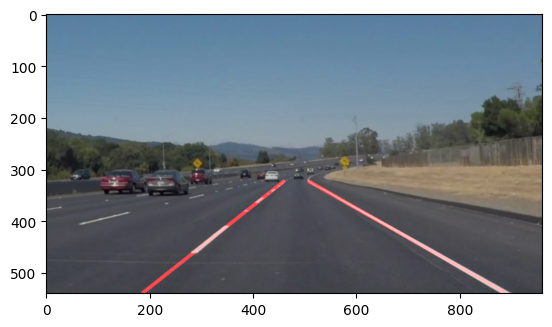

In [39]:
# Визуализация
averaged_lines = avg_lines (inputimage, lines)              # Усредните линии Хафа.
combined_image = draw_lines(inputimage, averaged_lines, 5)  # Добавление усредненных линий на исходное изображение

plt.imshow(combined_image);